# Generating Fake Chinese Characters by GAN

## Project description:  
In this notebook, we'll be generating images of artificial / "fake" Chinese Characters by using a generative adversarial network (GAN) trained on a dataset of images containing real Chinese characters. This learning data set was created by us via VBA programming within Microsoft PowerPoint. 

##Project Repo:
https://github.com/anitasafi/Generating-Fake-Chinese-Characters-by-GAN

##Participants:
Anita Safi, Sebastian Koch

##Course and Semester:
Generative Adversarial Networks/SoSe2021

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle as pkl
import numpy as np
import random
%matplotlib inline
import helper
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/Dataset_Fake_Chinese_Characters.zip" -d "/content/drive/MyDrive/Dataset_chinese_characters"

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset_chinese_characters'


# Loading Data

In [ ]:
## prepare data loader which helps to load the data

def get_dataloader(batch_size, image_size, data_dir='/content/drive/MyDrive/Dataset_chinese_characters'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #Implement function and return a dataloader
    
    images_dataset = datasets.ImageFolder(root=data_dir,
                                          transform=transforms.Compose([transforms.Resize(size=(image_size,image_size)),
                                                                        transforms.ToTensor()]))
    
    dataloader = torch.utils.data.DataLoader(images_dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

In [ ]:
batch_size = 32
img_size = 100

# Call your function and get a dataloader
CCD_train_loader = get_dataloader(batch_size, img_size)

### Visualizing the training data

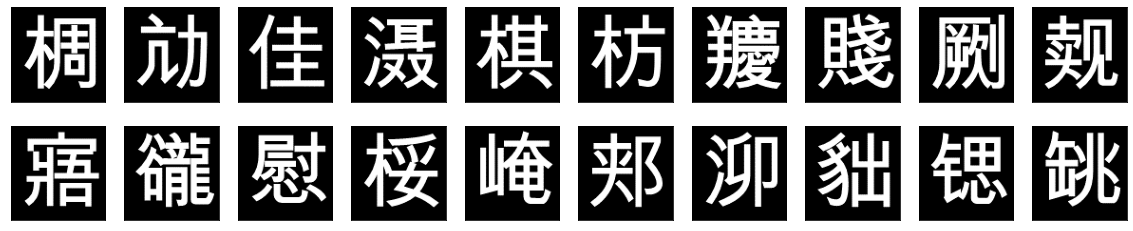

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(CCD_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

---
# Definition of the Model

As learned in the OpenCampus.SH-course including Coursera-materials a GAN consists of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator is a classifier network which has the task to judge wether an input picture seems to be fake (created by the generator) or real (being part of the training data).
Therefore the output needs to be between 0 and 1, which is why the Sigmoid function is used for the output layer of the network. By using [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) the Sigmoid function does not explicitly be programmed into the output layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # Here all hidden linear layers are defined
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # A final fully-connected layer is created
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer is also applied
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # In the forward function, first we need to flatten the image.
        x = x.view(-1, 100*100)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


## Generator

As in the example from the course we use  $tanh$ for the generator output. The latter therewith is be between -1 and 1.

**Why tanh activation function?**

It has been found out that the generator performs better with tanh. comparing to Leaky ReLU which allow a small non-zero output for negative input values, tanh scales the output to be between -1 and 1.

It should be considered that when these outputs go to Discriminator to be compared with real input pixel values, the values are between 0 and 1. So the real input images should also be rescaled that it would be applied later in training loop.



In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # Here all hidden linear layers are defined
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # A final fully-connected layer is created
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer is also applied
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Model hyperparameters



In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (100*100)
input_size = 10000
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 10000
# Size of first hidden layer in the generator
g_hidden_size = 32

## Build the network

Instantiation of discriminator and generator from the above classes.

In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=10000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---
## Calculation of Losses of Discriminator and Generator

### Discriminator Losses

Labels for real images are **reduced a bit from 1.0 to 0.9** in order  for the discriminator to generalize better (parameter `smooth` is used), as is suggested by the Coursera course material creators.

In [ ]:
# Calculate losses/ sum of the losses for real and fake images
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss() #combines a sigmoid activation function and and binary cross entropy loss in one function.
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Creating two Adam optimizers.

In [ ]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Defining two seprate Aptimizer, in order to update the discriminator and generator variables seprately. 
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Discriminator and generator are trained in an alternating fashion.


In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 500

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(CCD_train_loader):
                
        batch_size = real_images.size(0)
        
        ############ Since we have used tanh for generator, here we should rescale the output from discriminator, so they can match ############
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            Discriminator Training
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) #Draw samples from a uniform distribution/
                                                                #any value within the given interval is equally likely to be drawn.
        z = torch.from_numpy(z).float() #Creates a Tensor from a numpy.ndarray
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop to update discriminator's weight
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            Generator Training
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels! Reverse the order of elements in an array along the given axis.
        # The shape of the array is preserved, but the elements are reordered.
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  500] | d_loss: 1.3868 | g_loss: 0.7698
Epoch [    2/  500] | d_loss: 0.8656 | g_loss: 1.5722
Epoch [    3/  500] | d_loss: 1.1171 | g_loss: 1.0943
Epoch [    4/  500] | d_loss: 1.0676 | g_loss: 1.0715
Epoch [    5/  500] | d_loss: 0.7878 | g_loss: 1.7809
Epoch [    6/  500] | d_loss: 0.6721 | g_loss: 3.2523
Epoch [    7/  500] | d_loss: 1.0341 | g_loss: 2.0794
Epoch [    8/  500] | d_loss: 1.2036 | g_loss: 1.2169
Epoch [    9/  500] | d_loss: 1.0262 | g_loss: 0.9713
Epoch [   10/  500] | d_loss: 0.9309 | g_loss: 4.1574
Epoch [   11/  500] | d_loss: 0.9917 | g_loss: 5.5429
Epoch [   12/  500] | d_loss: 1.4608 | g_loss: 1.3043
Epoch [   13/  500] | d_loss: 1.2658 | g_loss: 1.8761
Epoch [   14/  500] | d_loss: 1.2109 | g_loss: 1.8048
Epoch [   15/  500] | d_loss: 1.2182 | g_loss: 1.2288
Epoch [   16/  500] | d_loss: 0.8931 | g_loss: 2.0212
Epoch [   17/  500] | d_loss: 1.0970 | g_loss: 1.6664
Epoch [   18/  500] | d_loss: 1.0500 | g_loss: 2.3205
Epoch [   19/  500] | d_loss

## Experimenting with the Model

with 2000 Images and 100 Epochs

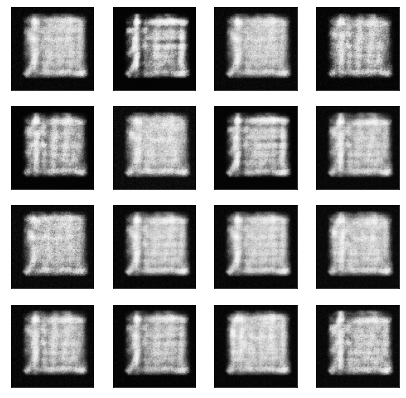



With 2000 Images and 1000 Epochs

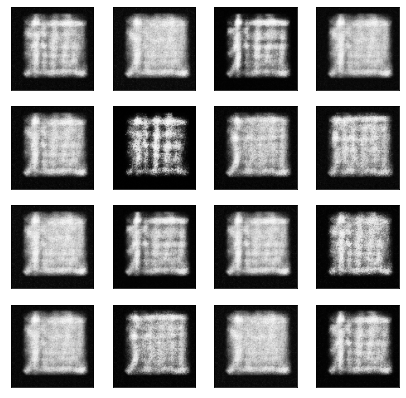

## Training loss
Training losses of the generator and discriminator per epoch.

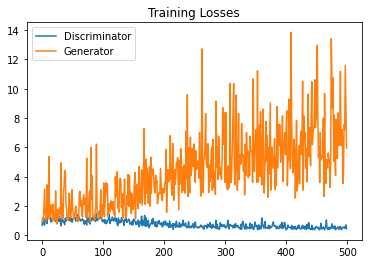

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((100,100)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Samples from final training epoch:

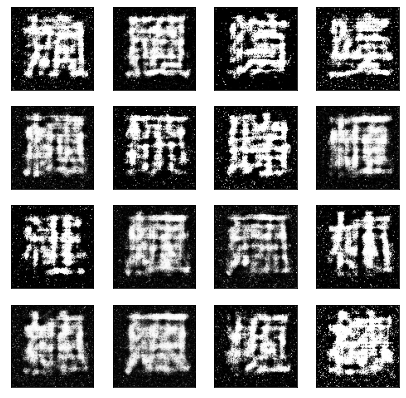

In [ ]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Generated images saved during training (10 epochs distance between rows):

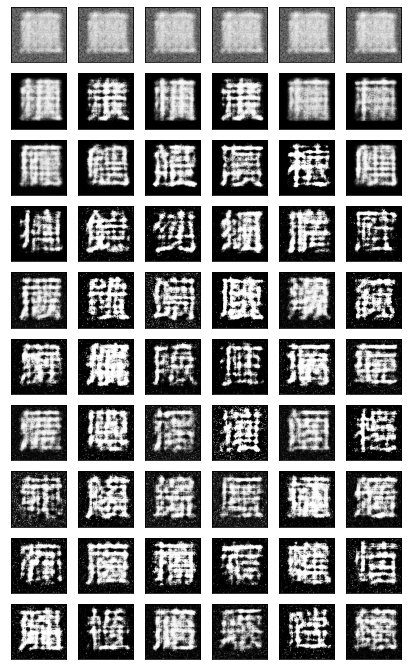

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((100,100)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

Some "fake" images generated by the final version of the generator:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


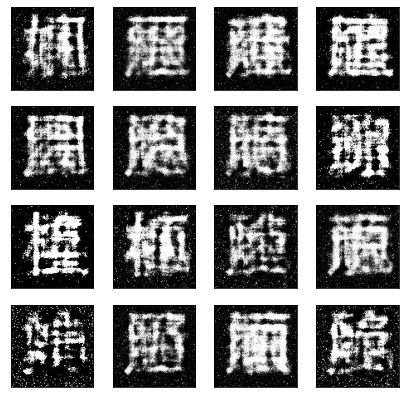

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

# Comparing the real and generated fake images 

Some nice similarities picked up by our GAN!



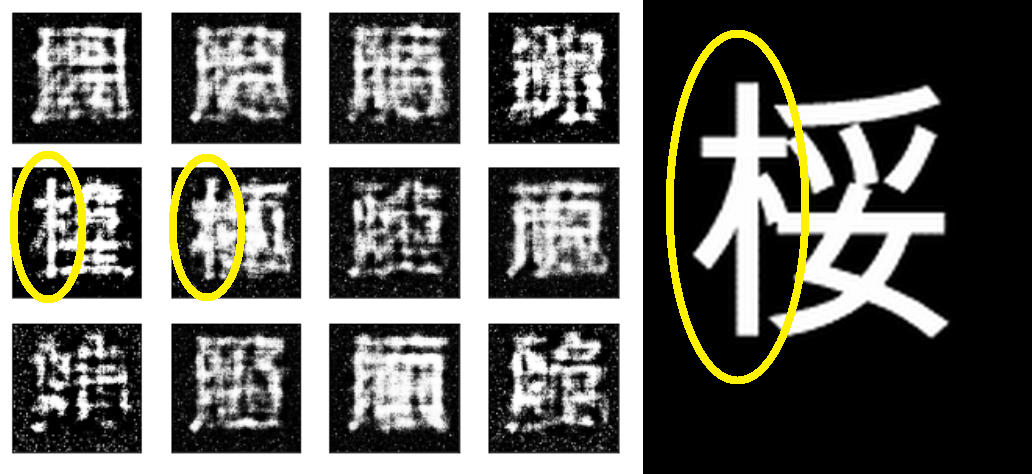